# Indian Address Tagger

The models is very simple and behaves like an Adapter transformer. The embeddings from a backbone model say `roberta-xlm` is used to train a simple linear kernel. This notebook has the following:
- preparation of data
- building of linear kernel
- train the linear kernel
- visualise and check results
- save params

In [22]:
import re
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
%matplotlib inline

rand = lambda: random.random()
rand()

0.46820569222560493

In [3]:
# first step is to create the dataset, for more details see addresses.txt
with open("./addresses.txt", "r") as f:
  data = f.read()
    
with open("./names.txt", "r") as f:
  names = f.read().split("\n")

data = re.sub(r"\s*#.*\n", "", data) # remove any comments
data = re.sub(r"\n+", "\n", data) # remove access newlines
splits = re.split(r"Street:", data)[1:] # split into parts
splits = [f"Street:{x}".split("\n")[:-1] for x in splits] # split address into lines

In [4]:
# from the splits create the dictionary objects
all_=[]
for x, n in zip(splits, np.random.choice(names, size = len(splits), replace = False)):
  data = {"name": n}
  for i,s in enumerate(x):
    splitter = ":" if i < 3 else "  "
    data[s.split(splitter)[0].strip()] = s.split(splitter)[1].strip()
  all_.append(data)

In [5]:
random.choice(all_)

{'name': 'Parikshit Merchant',
 'Street': '157/1, St Patricks Complex, 157/1,stpatrickscplx,brgdrdblr-25, Brigade Road',
 'City': 'Bangalore',
 'State/province/area': 'Karnataka',
 'Phone number': '25913579',
 'Zip code': '560025',
 'Country calling code': '+91',
 'Country': 'India'}

In [2]:
MODEL = "distilbert-base-cased"

In [6]:
# define the backbone models
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

In [7]:
def get_sample(x):
  # pass a random sample and return a formed sample
  text = ""

  # add name
  if rand() > 0.5:
    if rand() > 0.5:
      text += "From: "
    text += x["name"] + ", "

  # add address
  if rand() > 0.7:
    _s = random.choice([' ','\n'])
    text += f"{_s}Address: "
  text += x["Street"] + ", " + x["City"]
  if rand() > 0.2:
    text += ", " + x["State/province/area"]
  text += "-" + x["Zip code"]

  # add phone number
  phone_text = ""
  if rand() > 0.3:
    _s = random.choice([' ','\n'])
    _p = random.choice(['Phone Number','Mobile'])
    phone_text += f"{_s}{_p}: "
  if rand() > 0.9:
    phone_text += " +91-"
  if phone_text:
    text += phone_text + x["Phone number"]
  else:
    _s = random.choice([', ','\n'])
    text += _s + x["Phone number"]

  # tokenize and get spans
  text = text.strip()
  
  # name span
  try:
    span_name = text.index(x["name"])
    span_name = (span_name, span_name + len(x["name"]))
  except ValueError:
    span_name = None

  # address span
  span_add = text.index(x["Street"])
  span_add = (span_add, span_add+len(x["Street"]))
  span_city = text.index(x["City"])
  span_city = (span_city, span_city+len(x["City"]))
  try:
    span_state = text.index(x["State/province/area"])
    span_state = (span_state, span_state+len(x["State/province/area"]))
  except ValueError:
    span_state = None
  span_pin = text.index(x["Zip code"])
  span_pin = (span_pin, span_pin+len(x["Zip code"]))
  
  # phone span
  span_phone = text.index(x["Phone number"])
  span_phone = (span_phone, span_phone+len(x["Phone number"]))
  
  # create the dictionary
  data = {
    t:s
    for t, s in zip(
      ["name", "address", "city", "state", "pincode", "phone"],
      [span_name, span_add, span_city, span_state, span_pin, span_phone]
    )
  }
  data["text"] = text
  return data

def visualiser(data):
  # print the data from get_sample(...)
  text = data["text"]
  print(text)
  print("-" * 70)
  for t,s in data.items():
    if t == "text":
      continue
    if s is not None:
      print(t, "-->", text[s[0]:s[1]])

In [8]:
# check
sample = get_sample(random.choice(all_))
visualiser(sample)

2107, Panchratna, Opera House, Mumbai, Maharashtra-400004 Phone Number: 02223614567
----------------------------------------------------------------------
address --> 2107, Panchratna, Opera House
city --> Mumbai
state --> Maharashtra
pincode --> 400004
phone --> 02223614567


In [9]:
# define the labels, note that we need to provide the "null" as no-class
TAG_TO_ID = {x:i for i,x in enumerate(["null", "name", "address", "city", "state", "pincode", "phone"])}
ID_TO_TAG = {v:k for k,v in TAG_TO_ID.items()}
TAG_TO_ID, ID_TO_TAG

({'null': 0,
  'name': 1,
  'address': 2,
  'city': 3,
  'state': 4,
  'pincode': 5,
  'phone': 6},
 {0: 'null',
  1: 'name',
  2: 'address',
  3: 'city',
  4: 'state',
  5: 'pincode',
  6: 'phone'})

In [10]:
def convert_to_tensors(data):
  # this function is used to convert the data packets from get_sample(...)
  # into the tensors that are used to train the model
  tokenized = tokenizer(data["text"], return_offsets_mapping=True)
  offsets = np.array(tokenized["offset_mapping"])
  labels = np.zeros(len(tokenized["input_ids"])).astype(int)
  for t,s in data.items():
    if t != "text":
      if s is not None:
        start = (offsets[:, 0] != s[0]).argmin()
        end = (offsets[:, 1] != s[1]).argmin() + 1
        labels[start:end] = TAG_TO_ID[t]

  # first and last tokens are [CLS] and [SEP] so ignore those
  labels[0] = TAG_TO_ID["null"]
  labels[-1] = TAG_TO_ID["null"]
  
  return ({
    "input_ids": torch.Tensor(tokenized["input_ids"]).long(),
    "attention_mask": torch.Tensor(tokenized["attention_mask"]).long()
  },
  torch.from_numpy(labels).long())

def decode_predictions(inputs, labels):
  # does opposite of convert_to_tensors(...)
  ids = inputs["input_ids"]
  text = tokenizer.decode(ids[1:-1])
  spans = {}
  for i,l in enumerate(labels.tolist()):
    if l != 0: # ignore null_tokens
      if l in spans:
        spans[l].append(i)
      else:
        spans[l] = [i]
        
  ent = {
    ID_TO_TAG[k]: tokenizer.decode(ids[min(v):max(v) + 1])
    for k,v in spans.items()
  }
  
  for tag in TAG_TO_ID:
    if tag != "null" and tag not in ent:
      ent[tag] = None
  
  return {
    "text": text,
    "entities": ent
  }

In [11]:
# check
print(sample["text"])
inputs, targets = convert_to_tensors(sample)
decode_predictions(inputs, targets)

2107, Panchratna, Opera House, Mumbai, Maharashtra-400004 Phone Number: 02223614567


{'text': '2107, Panchratna, Opera House, Mumbai, Maharashtra - 400004 Phone Number : 02223614567',
 'entities': {'address': '2107, Panchratna, Opera House',
  'city': 'Mumbai',
  'state': 'Maharashtra',
  'pincode': '400004',
  'phone': '02223614567',
  'name': None}}

Now that data preparation is functions are ready we apply this on the entire data.

In [12]:
# create samples
samples = [get_sample(x) for x in all_]
random.choice(samples)

{'name': (0, 19),
 'address': (31, 69),
 'city': (71, 77),
 'state': (79, 90),
 'pincode': (91, 97),
 'phone': (98, 109),
 'text': 'Bhishma Saeed Murti,  Address: 302, Aniket Bldg, Kolbad, Thane (west), Mumbai, Maharashtra-400601\n02225478536'}

In [13]:
# convert to tensors
ds = [convert_to_tensors(x) for x in samples]
print(random.choice(ds))

({'input_ids': tensor([  101,   140,   118, 20818,   117,   157,  1204,  1665,  9825,  1665,
          117, 17037, 26281,  4638,   117,  8601,   118,  3434, 20829,  1571,
        26385,  7421,   131,  5507, 20581,  1559,  1545,  1604, 24606, 20829,
          102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])}, tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 5, 5, 5, 0, 0, 0, 6,
        6, 6, 6, 6, 6, 6, 0]))


In [14]:
# check
inputs, targets = random.choice(ds)
decode_predictions(inputs, targets)

{'text': 'From : Sankara Narayanaswamy, Aps House, Sant Pura, Nr Police Station, Tilak Nagar, Delhi, Delhi - 110018 Mobile : 01155458057',
 'entities': {'name': 'Sankara Narayanaswamy',
  'address': 'Aps House, Sant Pura, Nr Police Station, Tilak Nagar',
  'state': 'Delhi',
  'pincode': '110018',
  'phone': '01155458057',
  'city': None}}

In [15]:
# convert to padded batches
max_length = max([len(x[0]["input_ids"]) for x in ds])
ds_batched = {
  "input_ids": torch.zeros(len(ds), max_length).long(),
  "attention_mask": torch.zeros(len(ds), max_length).long(),
}
# -100 is ignored by torch.loss method
labels = torch.ones(len(ds), max_length).long() * -100
for i,x in enumerate(ds):
  x, y = x
  n = x["input_ids"].shape[0]
  ds_batched["input_ids"][i, :n] = x["input_ids"]
  ds_batched["attention_mask"][i, :n] = 1
  labels[i, :n] = y

In [16]:
# check if everything looks okay
ds_batched, labels

({'input_ids': tensor([[  101,   139, 27516,  ...,     0,     0,     0],
          [  101, 24930, 18380,  ...,     0,     0,     0],
          [  101,   141,  1969,  ...,     0,     0,     0],
          ...,
          [  101, 10601,   117,  ...,     0,     0,     0],
          [  101,  8347,   117,  ...,     0,     0,     0],
          [  101,  1622,   131,  ...,     0,     0,     0]]),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]])},
 tensor([[   0,    1,    1,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100],
         [   0,    2,    2,  ..., -100, -100, -100],
         ...,
         [   0,    2,    2,  ..., -100, -100, -100],
         [   0,    2,    2,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100]]))

Note that in this notebook we provide a very basic training system, for production system you might want to check your own datasets. However the gist of it remains the same.

In [17]:
# split into test train set
# in total we have 120 samples so first 100 -> train and others are test
train_batched = {
  "input_ids": ds_batched["input_ids"][:100],
  "attention_mask": ds_batched["attention_mask"][:100],
}
train_labels = labels[:100]
test_batched = {
  "input_ids": ds_batched["input_ids"][100:],
  "attention_mask": ds_batched["attention_mask"][100:],
}
test_labels = labels[100:]

In [18]:
# pass this once and not again for training
with torch.no_grad():
  train_logits = model(**train_batched).last_hidden_state
  test_logits = model(**test_batched).last_hidden_state

In [19]:
# define classifier head
class IndicAddressTagger(nn.Module):
  def __init__(self, i, c):
    super().__init__()
    self.w = nn.Parameter(data = torch.normal(mean = 0, std = 0.02, size = [i,c]), requires_grad=True)
    self.b = nn.Parameter(data = torch.zeros([c,]))
  def forward(self, x):
    return x@self.w + self.b

In [24]:
def accuracy(x, y):
  mask = y != -100
  corr = sum(x[mask] == y[mask])
  return corr / sum(mask)

# define the classifier and train the model for 500 steps, logging in between
c = IndicAddressTagger(model.config.dim, len(TAG_TO_ID))
optim = torch.optim.Adam(c.parameters(), lr = 0.001)
test_losses = []
train_losses = []
for i in range(500):
  # train forward pass
  flogits = c(train_logits)
  flogits_flat = flogits.contiguous().view(-1, flogits.shape[-1])
  targets = train_labels.view(-1,)
  train_loss = F.cross_entropy(flogits_flat, targets)
  train_acc = accuracy(flogits_flat.argmax(-1), targets)
  train_losses.append(train_loss)
  
  # train backward pass
  optim.zero_grad()
  train_loss.backward()
  optim.step()
  
  # test
  with torch.no_grad():
    flogits = c(test_logits)
    flogits_flat = flogits.contiguous().view(-1, flogits.shape[-1])
    targets = test_labels.view(-1,)
    test_loss = F.cross_entropy(flogits_flat, targets)
    test_acc = accuracy(flogits_flat.argmax(-1), targets)
    test_losses.append(test_loss)
    
  if (i + 1) % 25 == 0:
    print(f"Epoch: {i+1} | Train: {train_loss:.3f} | Test: {test_loss:.3f} | Train Acc.: {train_acc:.3f} | Test Acc.: {test_acc:.3f}")

Epoch: 25 | Train: 0.729 | Test: 0.712 | Train Acc.: 0.793 | Test Acc.: 0.808
Epoch: 50 | Train: 0.438 | Test: 0.425 | Train Acc.: 0.880 | Test Acc.: 0.893
Epoch: 75 | Train: 0.319 | Test: 0.309 | Train Acc.: 0.924 | Test Acc.: 0.932
Epoch: 100 | Train: 0.254 | Test: 0.245 | Train Acc.: 0.941 | Test Acc.: 0.944
Epoch: 125 | Train: 0.213 | Test: 0.205 | Train Acc.: 0.951 | Test Acc.: 0.949
Epoch: 150 | Train: 0.184 | Test: 0.178 | Train Acc.: 0.958 | Test Acc.: 0.962
Epoch: 175 | Train: 0.162 | Test: 0.157 | Train Acc.: 0.963 | Test Acc.: 0.963
Epoch: 200 | Train: 0.146 | Test: 0.142 | Train Acc.: 0.969 | Test Acc.: 0.965
Epoch: 225 | Train: 0.132 | Test: 0.129 | Train Acc.: 0.972 | Test Acc.: 0.968
Epoch: 250 | Train: 0.121 | Test: 0.119 | Train Acc.: 0.976 | Test Acc.: 0.968
Epoch: 275 | Train: 0.112 | Test: 0.111 | Train Acc.: 0.979 | Test Acc.: 0.971
Epoch: 300 | Train: 0.104 | Test: 0.104 | Train Acc.: 0.981 | Test Acc.: 0.973
Epoch: 325 | Train: 0.097 | Test: 0.098 | Train Acc.: 0

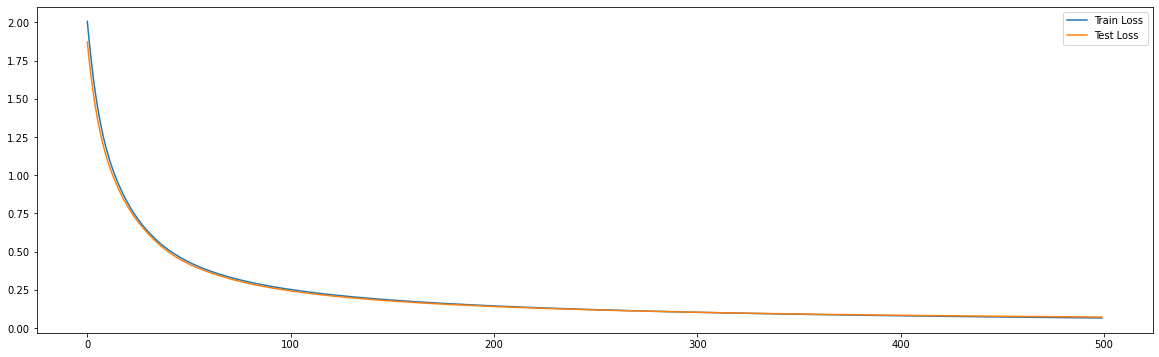

In [25]:
# visualise the results
plt.figure(figsize = (20, 6))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["Train Loss", "Test Loss"])

In [26]:
def infer(text):
  # method to perform inference on input text and return industry standard api
  ids = tokenizer(text, return_tensors = "pt")
  with torch.no_grad():
    logits = model(**ids).last_hidden_state
    logits = c(logits)
    labels = logits.argmax(-1)
  ids = {k:v[0] for k,v in ids.items()}
  out = decode_predictions(ids, labels[0])
  
  # convert to industry standard response
  text = out["text"]
  entities = []
  for ent in out["entities"]:
    if out["entities"][ent] is None:
      data = {
        "text": None,
        "start": 0,
        "end": 0,
        "entity": ent
      }
    else:
      data = {
        "text": out["entities"][ent],
        "start": text.index(out["entities"][ent]),
        "end": text.index(out["entities"][ent]) + len(out["entities"][ent]),
        "entity": ent
      }
    entities.append(data)
  return {
    "text": text,
    "entities": entities
  }

In [29]:
# test any random string
infer("By: Ankush Agarwal, Fl. 4, Seaside Apartment, Airoli, Mumbai, Maharashtra \n\n Mobile : 9834529842")

{'text': 'By : Ankush Agarwal, Fl. 4, Seaside Apartment, Airoli, Mumbai, Maharashtra Mobile : 9834529842',
 'entities': [{'text': 'Ankush Agarwal',
   'start': 5,
   'end': 19,
   'entity': 'name'},
  {'text': 'Fl. 4, Seaside Apartment, Airoli',
   'start': 21,
   'end': 53,
   'entity': 'address'},
  {'text': 'Mumbai', 'start': 55, 'end': 61, 'entity': 'city'},
  {'text': 'Maharashtra', 'start': 63, 'end': 74, 'entity': 'state'},
  {'text': '9834529842', 'start': 84, 'end': 94, 'entity': 'phone'},
  {'text': None, 'start': 0, 'end': 0, 'entity': 'pincode'}]}

In [30]:
# save the weights and exit
ws = np.vstack([c.w.detach().numpy(), c.b.view(1, c.b.shape[-1]).detach().numpy()])
np.save("./params.npy", ws)

Now we can deploy this thing, check the `run.py` file for a streamlit interactive server.